# Problem Set 3

Ari Boyarsky

aboyarsky@uchicago.edu

First we import requisite packages:

In [786]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.stats as sts
from scipy import integrate
from scipy.stats import lognorm
import numpy.linalg as la
import math

### Problem 1

**Part (a)** Plota histogram of *income.txt* with 30 bins.

In [787]:
incomes = pd.read_csv("incomes.txt", header = None)
incomes.rename(columns={0: 'Income'}, inplace=True)
incomes.head()

,Income
0,53711.544399
1,99731.233349
2,84773.605417
3,75184.025931
4,73390.955933


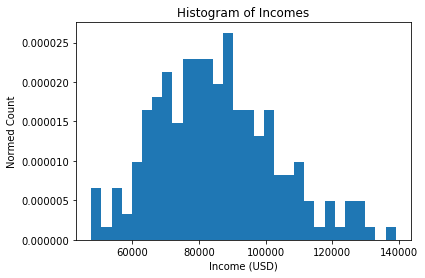

In [788]:
plt.hist(incomes["Income"], bins = 30, normed=True)
plt.ylabel("Normed Count")
plt.xlabel("Income (USD)")
plt.title("Histogram of Incomes")
plt.show()

**Part (b)** Estimate lognormal parameters using GMM. Using avg income, and std. dev. of income as two momemnts. Let $\hat{\textbf{W}} = \textbf{I}$. Plot estimated pdf against histogram.

We use the lognormal pdf from the previous problem set.

In [789]:
# PDF of log norm
def log_norm(x, mu, sd):
    '''
    --------------------------------------------------------------------
    This function simulates a log normal pdf with mean mu 
    and variance sigma^2 (sd sigma).  
    --------------------------------------------------------------------
    INPUTS:
    x: vector (array), log normally dist. rand var
    mu: scalar, log normal mean
    sd: scalar > 0, std dev of log normal
    --------------------------------------------------------------------
    RETURNS: value of pdf
    --------------------------------------------------------------------
    '''
    sigma = sd
    return ((1/(x*sigma*np.sqrt(2*np.pi)))*np.exp(-(((np.log(x)-mu)**2)/(2*(sigma**2)))))

    

Now, we define our criterion function:

In [790]:
# This section is heavily based on lecture notes by Dr. Rick Evans (Winter 2018).
def data_moments(x):
    mean = x.mean()
    sd = np.sqrt(x.var())
    
    return mean, sd

def model_moments(mu, sd):
    # expection of x ~ LN, then E(x) = int(xf(x))
    #(mean, e) = integrate.quad(lambda x: x * log_norm(x, mu, sd), 0.001, np.inf)
    #(mean, e) = integrate.quad(lambda x: x * log_norm(x, mu, sd), 1e-10, np.inf)
    #mean = np.log(mean)
    # Recall, variance is given by Var(X) = E(X)^2 - E(X^2) = E(X^2 - mu), thus
    #(sd, e) = integrate.quad(lambda x: ((x**2) * log_norm(x, mu, sd)), 1e-10, np.inf)
    #(sd, e) = integrate.quad(lambda x: ((x**2) * sts.norm.pdf(x, mu, sd)), 1e-10, np.inf)
    #variance = np.log(variance)
    #variance = mean**2 - variance   
    
    # Integrating the log normal rsults yields improper results with a large error and little stability,
    # thus, I choose the analytic formulas for mean and variance as these are more consistent
    var = sd**2
    mean = np.exp(mu + (var/2))
    sd = np.sqrt((np.exp(var)-1)*(np.exp(2*mu + var)))
                                  
    return mean, sd

def errs(x, mu, sd):
    dm = np.array(data_moments(x)).reshape((2,1))
    mm = np.array(model_moments(mu, sd)).reshape((2,1))
    return ((dm - mm)/dm)

def criterion(params, *args):
    mu, sd = params
    x, W = args 
    err = errs(x, mu, sd)
    return np.dot(np.dot(err.T, W), err)


In [791]:
mu = np.log(incomes["Income"].values).mean()
sd = np.sqrt(np.log(incomes["Income"].values).var())
params = np.array([mu, sd])
res = minimize(criterion, params, args=(incomes["Income"].values, np.eye(2)), method='L-BFGS-B', bounds=((None, None), (1e-10, None)))

In [792]:
res.x

array([ 11.33188484,   0.20869633])

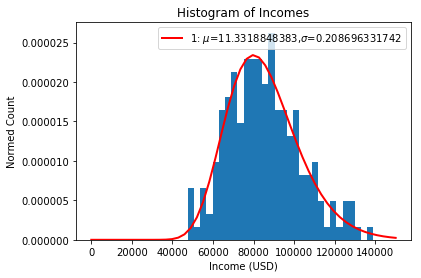

In [828]:
plt.clf()
plt.hist(incomes["Income"], bins = 30, normed=True)
x = np.linspace(1e-10,150000)
plt.plot(x, log_norm(x, res.x[0], res.x[1]),
         linewidth=2, color='r', label='1: $\mu$='+str(res.x[0])+',$\sigma$='+str(res.x[1]))
plt.ylabel("Normed Count")
plt.xlabel("Income (USD)")
plt.title("Histogram of Incomes")
plt.legend()
plt.show()

In [834]:
gmm_b_mu, gmm_b_sd = res.x
mean_data, sd_data = data_moments(incomes["Income"])
mean_model, sd_model = model_moments(res.x[0], res.x[1])
err = errs(incomes["Income"], res.x[0], res.x[1]).reshape(2,)
print('Data Mean  =', mean_data, ', Data SD =', sd_data)
print('Model Mean =', mean_model, ', Model SD =', sd_model)
print('Error vector=', err)
print('Crit. Function Value= ', res.fun[0])
res

Data Mean  = 85276.82360625808 , Data SD = 18037.6928694
Model Mean = 85277.1583751 , Model SD = 17992.5836974
Error vector= [ -3.92567258e-06   2.50082825e-03]
Crit. Function Value=  [  2.07487051e-11]


      fun: array([[  2.07487051e-11]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.24921238e-05,   2.54906503e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 27
      nit: 7
   status: 0
  success: True
        x: array([ 11.33188484,   0.20869633])

Thus, the estmated GMM parameter values are $\mu = 11.331$ and $\text{std. dev.} = 0.0208$. The data moments and model moments listed above are extremely simmilar. Indeed, our error vectors are quite small. There is a larger gap in SD however. The value of the crit function is $2.07487051E-11$.

**Part (c)** Two step GMM.

In [795]:
err1 = errs(incomes["Income"], res.x[0], res.x[1])
VCV = np.dot(err1, err1.T) / incomes["Income"].shape[0]
W = la.pinv(VCV) 
params = np.array([res.x[0], res.x[1]])
results = minimize(criterion, params, args=(incomes["Income"], W),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))

In [835]:
mean_data, sd_data = data_moments(incomes["Income"])
mean_model, sd_model = model_moments(res.x[0], res.x[1])
err = errs(incomes["Income"], res.x[0], res.x[1]).reshape(2,)
print('Data Mean  =', mean_data, ', Data sd =', sd_data)
print('Model Mean =', mean_model, ', Model sd =', sd_model)
print('Error vector=', err)
print('Crit. Function Value= ', res.fun[0])
res

Data Mean  = 85276.82360625808 , Data sd = 18037.6928694
Model Mean = 85277.1583751 , Model sd = 17992.5836974
Error vector= [ -3.92567258e-06   2.50082825e-03]
Crit. Function Value=  [  2.07487051e-11]


      fun: array([[  2.07487051e-11]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.24921238e-05,   2.54906503e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 27
      nit: 7
   status: 0
  success: True
        x: array([ 11.33188484,   0.20869633])

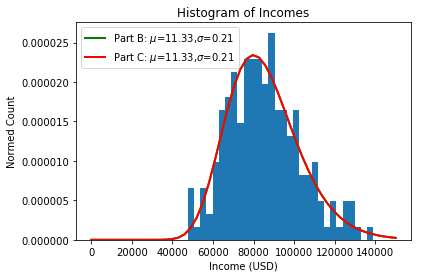

In [797]:
plt.clf()
plt.hist(incomes["Income"], bins = 30, normed=True)
x = np.linspace(1e-10,150000)
plt.plot(x, log_norm(x, gmm_b_mu, gmm_b_sd),
         linewidth=2, color='g', label='Part B: $\mu$='+ str(gmm_b_mu.round(2))+',$\sigma$='+ str(gmm_b_sd.round(2)))
plt.plot(x, log_norm(x, res.x[0], res.x[1]),
         linewidth=2, color='r', label='Part C: $\mu$='+ str(res.x[0].round(2))+',$\sigma$='+ str(res.x[1].round(2)))
plt.ylabel("Normed Count")
plt.xlabel("Income (USD)")
plt.title("Histogram of Incomes")
plt.legend()
plt.show()

Again, the estmated GMM parameter values are $\mu = 11.331$ and $\text{std. dev.} = 0.0208$. The data moments and model moments listed above are extremely simmilar. Indeed, our error vectors are quite small. There is a larger gap in SD however. The value of the crit function is $2.07487051E-11$. Same values as part b. This must be becuase our initial estimate was very good, so two-step had little effect. 

**Part (d)** Using percent of individuals who earn less than $75,000, between $75,000 and \$100,000 and more than $100,000 as moments.

In [814]:
def new_data_moments(x):
    N = len(x)
    i = np.array(x)
    m_un = sum(i < 75000)/N
    m_bet = np.all((i >= 75000, i <= 100000), axis = 0).sum()/N
    m_up = sum(i > 100000)/N
    
    return m_un, m_bet, m_up

def cdf_LN(x, mu, sd):
    return integrate.quad(lambda x: log_norm(x, mu, sd), 1e-10, x)

def new_model_moments(mu, sd):
    m_un = cdf_LN(75000, mu, sd)[0]
    m_bet = cdf_LN(100000, mu, sd)[0] - m_un
    m_up = 1 - cdf_LN(100000, mu, sd)[0]
    return m_un, m_bet, m_up

def new_errs(x, mu, sd):
    md = np.array(new_data_moments(x)).reshape((3,1))
    mm = np.array(new_model_moments(mu, sd)).reshape((3,1))
    return (md - mm)/md

def new_criterion(params, *args):
    mu, sd = params
    x, W = args 
    err = new_errs(x, mu, sd)
    return err.T @ W @ err

In [815]:
params = np.array([11, 0.5])
resd = minimize(new_criterion, params, args=(incomes["Income"].values, np.eye(3)), method='L-BFGS-B', bounds=((None, None), (0.001, None)))

In [816]:
resd.x

array([ 11.33568132,   0.21059845])

In [833]:
under, between, over = new_data_moments(incomes["Income"])
under_model, between_model, over_model = new_model_moments(resd.x[0], resd.x[1])
err = errs(incomes["Income"], resd.x[0], resd.x[1]).reshape(2,)
print('Data: Under 75:  =', under, ', Data Between 75-100 =', between, ', Over 100k = ',over)
print('Data: Under 75:  =', under_model, ', Data Between 75-100 =', between_model, ', Over 100k = ',over_model)
print('Error vector=', err)
print('Crit. Function Value= ', resd.fun[0])
resd

Data: Under 75:  = 0.3 , Data Between 75-100 = 0.5 , Over 100k =  0.2
Data: Under 75:  = 0.30000000683293615 , Data Between 75-100 = 0.5000000086205884 , Over 100k =  0.1999999845464755
Error vector= [-0.00420802 -0.0110255 ]
Crit. Function Value=  [  6.78631052e-15]


      fun: array([[  6.78631052e-15]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -5.06880213e-07,  -3.16122863e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 63
      nit: 8
   status: 0
  success: True
        x: array([ 11.33568132,   0.21059845])

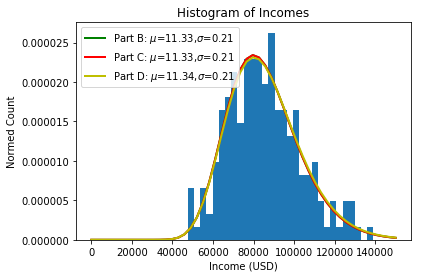

In [818]:
plt.clf()
plt.hist(incomes["Income"], bins = 30, normed=True)
x = np.linspace(1e-10,150000)
plt.plot(x, log_norm(x, gmm_b_mu, gmm_b_sd),
         linewidth=2, color='g', label='Part B: $\mu$='+ str(gmm_b_mu.round(2))+',$\sigma$='+ str(gmm_b_sd.round(2)))
plt.plot(x, log_norm(x, res.x[0], res.x[1]),
         linewidth=2, color='r', label='Part C: $\mu$='+ str(res.x[0].round(2))+',$\sigma$='+ str(res.x[1].round(2)))
plt.plot(x, log_norm(x, resd.x[0], resd.x[1]),
         linewidth=2, color='y', label='Part D: $\mu$='+ str(resd.x[0].round(2))+',$\sigma$='+ str(resd.x[1].round(2)))
plt.ylabel("Normed Count")
plt.xlabel("Income (USD)")
plt.title("Histogram of Incomes")
plt.legend()
plt.show()

The results are a little different this time. Model and data moments are very close as they should be. Error values are larger however, so these moments are not as effetcive it seems. Additionally, the mu and sigma are slightly different. Please note all values are reported above.  

**Part (e)** Two step of **(d)**.

In [819]:
errd = new_errs(incomes["Income"], resd.x[0], resd.x[1])
VCV = np.dot(errd, errd.T) / incomes["Income"].shape[0]
W = la.pinv(VCV) 
params = np.array([resd.x[0], resd.x[1]])
results_e = minimize(new_criterion, params, args=(incomes["Income"], W),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))

In [832]:
under, between, over = new_data_moments(incomes["Income"])
under_model, between_model, over_model = new_model_moments(results_e.x[0], results_e.x[1])
err = errs(incomes["Income"], results_e.x[0], results_e.x[1]).reshape(2,)
print('Data: Under 75:  =', under, ', Data Between 75-100 =', between, ', Over 100k = ',over)
print('Data: Under 75:  =', under_model, ', Data Between 75-100 =', between_model, ', Over 100k = ',over_model)
print('Error vector=', err)
print('Crit. Function Value= ', results_e.fun[0])
results_e

Data: Under 75:  = 0.3 , Data Between 75-100 = 0.5 , Over 100k =  0.2
Data: Under 75:  = 0.3000000012241351 , Data Between 75-100 = 0.49999999921763033 , Over 100k =  0.19999999955823455
Error vector= [-0.00420802 -0.01102553]
Crit. Function Value=  [ 0.24316782]


      fun: array([[ 0.24316782]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.58278462e+10,   7.32155422e+09])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 138
      nit: 2
   status: 2
  success: False
        x: array([ 11.33568133,   0.21059846])

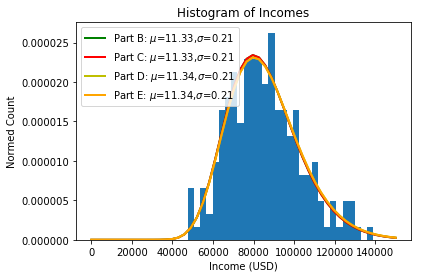

In [821]:
plt.clf()
plt.hist(incomes["Income"], bins = 30, normed=True)
x = np.linspace(1e-10,150000)
plt.plot(x, log_norm(x, gmm_b_mu, gmm_b_sd),
         linewidth=2, color='g', label='Part B: $\mu$='+ str(gmm_b_mu.round(2))+',$\sigma$='+ str(gmm_b_sd.round(2)))
plt.plot(x, log_norm(x, res.x[0], res.x[1]),
         linewidth=2, color='r', label='Part C: $\mu$='+ str(res.x[0].round(2))+',$\sigma$='+ str(res.x[1].round(2)))
plt.plot(x, log_norm(x, resd.x[0], resd.x[1]),
         linewidth=2, color='y', label='Part D: $\mu$='+ str(resd.x[0].round(2))+',$\sigma$='+ str(resd.x[1].round(2)))
plt.plot(x, log_norm(x, results_e.x[0], results_e.x[1]),
         linewidth=2, color='orange', label='Part E: $\mu$='+ str(results_e.x[0].round(2))+',$\sigma$='+ str(results_e.x[1].round(2)))
plt.ylabel("Normed Count")
plt.xlabel("Income (USD)")
plt.title("Histogram of Incomes")
plt.legend()
plt.show()

Results are the same as the previous part. Model and data moments are very close as they should be. Error values are larger however, so these moments are not as effetcive it seems. Additionally, the mu and sigma are slightly different. Please note all values are reported above.  

**Part (f)** All four estimates are extremely simmilar. Indeed, they each minimize distance at almost the same parameters. That said I would choose part b's method as mean and std. dev. are perhaps more robust and standard moment choices.Additionally, some tetsing reveals that it is very stable. It also does *not* use two step method and so there is less computational overhead for the same results. Also the moments are perhaps more defensible than the arbitrary moments in (d) and (e). That is mean and sd are more standard and do not use an arbitrary cutoff like 75k and 100k.


## Question 2

**Part (a)**

In [837]:
sick = pd.read_csv("sick.txt")
sick.head()

,sick,age,children,avgtemp_winter
0,1.67,57.47,3.04,54.10
1,0.71,26.77,1.20,36.54
2,1.39,41.85,2.31,32.38
3,1.37,51.27,2.46,52.94
4,1.45,44.22,2.72,45.90


In [838]:
def ols_data_moment(x):
    m = x["sick"].values
    return m

def ols_model_moment(x, betas):
    N = x.shape[0]
    X = np.concatenate((np.ones((N,1)),x.values[:,1:]), axis = 1)
    return X @ betas

def ols_errs(x, betas, W):
    errors = ols_model_moment(x, betas) - ols_data_moment(x)
    return errors.T @ W @ errors
def ols_crit(params, *args):
    betas = params
    x, W = args 
    return ols_errs(x, betas, W)
   

In [839]:
betas_init = np.array([1,1,1,1])
ols_res = minimize(ols_crit, betas_init, args=(sick, np.eye(len(sick))), method='L-BFGS-B', bounds=((None, None), (None, None), (None, None), (None, None)))

In [840]:
for i in range(0, len(ols_res.x)):
    print("Beta "+ str(i) +" = "+ str(ols_res.x[i]))

Beta 0 = 0.251644217151
Beta 1 = 0.0129333956393
Beta 2 = 0.400501622583
Beta 3 = -0.00999164445085


Notice, that these are the same values that we calculated using MLE. Below we report our resuluts:

In [844]:
data_m = ols_data_moment(sick)
model_m= ols_model_moment(sick, ols_res.x)
err_ols = ols_errs(sick, ols_res.x, np.eye(len(sick)))
print('Data Moment:  =', data_m)
print('Model Moment:  =', model_m)
print('Error vector=', err)
print('Crit. Function Value= ', ols_res.fun)
ols_res

Data Moment:  = [ 1.67  0.71  1.39  1.37  1.45  0.62  1.06  1.29  1.05  1.18  1.21  0.63
  0.67  0.64  0.86  1.25  0.88  0.12  1.53  1.36  0.73  0.15  0.6   1.28
  0.89  0.46  1.03  0.42  0.6   1.86  1.1   1.35  1.11  2.04  0.89  0.69
  1.58  0.86  0.81  0.81  1.04  1.68  1.36  0.37  1.05  2.8   1.03  1.22
  1.83  1.25  1.02  0.89  1.98  1.51  1.14  1.18  0.79  1.66  1.21  0.5
  1.51  0.81  0.64  1.35  0.2   0.66  1.04  1.88  0.55  1.01  0.81  0.95
  1.27  0.78  0.9   0.96  0.79  0.56  1.81  1.63  0.63  0.91  0.66  0.53
  0.96  2.11  0.07  0.59  1.15  0.11  1.06  1.72  0.26  0.93  1.61  1.48
  0.65  1.58  1.16  0.14  0.96  0.65  0.12  0.12  0.86  0.08  1.92  1.56
  1.49  1.32  0.13  1.34  0.61  0.97  0.65  0.49  1.18  0.88  0.46  1.42
  0.56  0.95  1.52  1.2   1.16  1.3   1.22  0.54  1.47  1.97  0.51  0.05
  1.12  0.99  0.91  0.87  0.7   2.12  0.5   0.65  0.8   0.04  2.11  0.78
  0.23  0.4   1.19  1.09  2.22  0.79  1.66  1.28  1.9   1.61  0.93  1.11
  0.74  1.68  1.72  0.27  0.2   0.57

      fun: 0.0018212898261221629
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([  9.27634922e-05,   3.82880576e-03,   1.30814955e-04,
         4.91669741e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 110
      nit: 14
   status: 0
  success: True
        x: array([ 0.25164422,  0.0129334 ,  0.40050162, -0.00999164])

### Robustness Check -- Comparison to OLS model

In [846]:
import statsmodels.formula.api as sm

In [848]:
result = sm.ols(formula = "sick ~ age + children + avgtemp_winter", data = sick).fit()

In [851]:
print(result.params)
print(result.summary())

Intercept         0.251641
age               0.012934
children          0.400499
avgtemp_winter   -0.009992
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                   sick   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.815e+06
Date:                Sun, 21 Jan 2018   Prob (F-statistic):               0.00
Time:                        14:24:06   Log-Likelihood:                 876.87
No. Observations:                 200   AIC:                            -1746.
Df Residuals:                     196   BIC:                            -1733.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----

In [ ]:
The same as when we estimated parameters with GMM. $R^2 = 1$ suggests its a perfect fit